rBergomi demo
==

We demonstrate the rough Bergomi (rBergomi) price process introduced by [Bayer, Friz and Gatheral](https://ssrn.com/abstract=2554754), which we define here by

$$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\},\quad B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2, $$

$$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}, \quad Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u,$$

for Brownian motion $(W^1, W^2)$. The *hybrid scheme* of [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004) is used for efficient, $\mathcal{O}(n\log n)$, simulation of the Volterra process, $Y_t^a$.

From $N$ samples of the price process, $\{S^i_t\}_{i = 1}^N$ , we show implied volatilities, $\hat{\sigma}^N_{BS}(k,t)$,  estimated using the following estimator,

$$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0),$$

as described in [McCrickerd and Pakkanen](https://arxiv.org/abs/1708.02563).

Change directory to folder with rBergomi scripts

In [1]:
import os
os.chdir('/Users/ryanmccrickerd/desktop/rough_bergomi/rbergomi')

Import required libraries, classes and functions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
% matplotlib inline

Create instance of the rBergomi class with $n$ steps per year, $N$ paths, maximum maturity $T$ and roughness index $a$

In [3]:
rB = rBergomi(n = 100, N = 30000, T = 1.0, a = -0.43)

Fix the generator's seed for replicable results

In [4]:
np.random.seed(0)

Generate required Brownian increments

In [5]:
dW1 = rB.dW1()
dW2 = rB.dW2()

Construct the Volterra process, $$Y_t^a := \sqrt{2a + 1} \int_0^t (t - u)^a  \mathrm{d}W^1_u$$

In [6]:
Y = rB.Y(dW1)

Correlate the orthogonal increments, using $\rho$, $$B_u:=\rho W_u^1 + \sqrt{1 - \rho^2}W_u^2$$

In [7]:
dB = rB.dB(dW1, dW2, rho = -0.9)

Construct the variance process, using $\xi$ and $\eta$, $$V_t := \xi\ \exp \left\{ \eta Y^a_t - \frac{\eta^2}{2} t^{2a + 1}\right\}$$

In [8]:
V = rB.V(Y, xi = 0.235**2, eta = 1.9) 

Finally construct the price process, $$S_t := \exp \left\{ \int_0^t \sqrt{ V_u } \mathrm{d}B_u - \frac{1}{2}\int_0^t V_u \mathrm{d}u \right\}$$

In [9]:
S = rB.S(V, dB)

Now replicate implied volatiliies shared by [Bennedsen, Lunde and Pakkanen](https://arxiv.org/abs/1507.03004). Fix the log-strike range, $k$

In [10]:
k = np.arange(-0.5, 0.51, 0.01)

Compute call payoffs, prices, and implied volatilities, $$\hat{\sigma}^N_{BS}(k,t)^2 t = BS^{-1}\left(\hat{C}_N(k,t)\right),\quad \hat{C}_N(k,t) = \frac{1}{N}\sum_{i = 1}^N \max(S^i_t - e^k, 0)$$

In [11]:
ST = S[:,-1][:,np.newaxis]
K = np.exp(k)[np.newaxis,:]
call_payoffs = np.maximum(ST - K,0)
call_prices = np.mean(call_payoffs, axis = 0)[:,np.newaxis]
implied_vols = vec_bsinv(call_prices, 1., np.transpose(K), rB.T)

Plot implied volatilities 

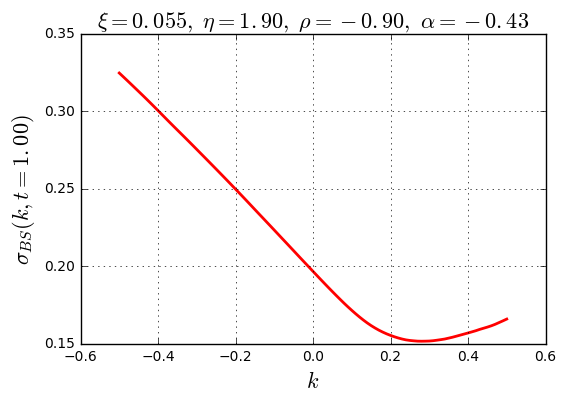

In [12]:
plot, axes = plt.subplots()
axes.plot(k,implied_vols, 'r', lw=2)
axes.set_xlabel(r'$k$', fontsize=16)
axes.set_ylabel(r'$\sigma_{BS}(k,t=%.2f)$'%rB.T, fontsize=16)
title = r'$\xi=%.3f,\ \eta=%.2f,\ \rho=%.2f,\ \alpha=%.2f $'
axes.set_title(title%(rB.xi, rB.eta, rB.rho, rB.a), fontsize=16)
plt.grid(True)

Now we verify some properties of the processes $Y_t^a$, $V_t$ and $S_t$. Set the number of paths to observe

In [13]:
paths = 0

Firstly compute moments of the Volterra process, $$\mathbb{E}[Y_t^a] = 0,\quad \mathbb{V}\left[Y_t^a\right] = t^{2a + 1}$$

In [14]:
eY1 = 0 * rB.t # Known expectation
vY1 = rB.t**(2*rB.a + 1) # Known variance
eY2 = np.mean(Y, axis=0, keepdims=True) # Observed expectation
vY2 = np.var(Y, axis=0, keepdims=True) # Observed variance

and plot these

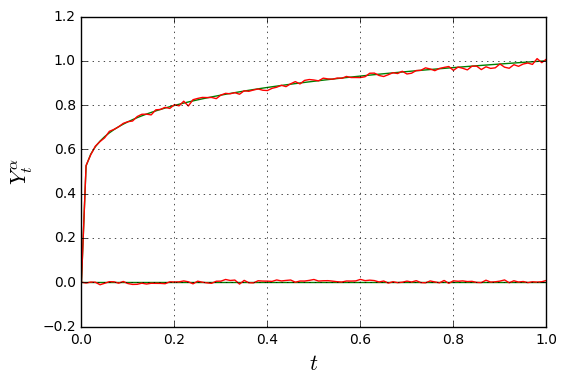

In [15]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], eY1[0,:], 'g')
axes.plot(rB.t[0,:], vY1[0,:], 'g')
axes.plot(rB.t[0,:], eY2[0,:], 'r')
axes.plot(rB.t[0,:], vY2[0,:], 'r')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(Y[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$Y^\alpha_t$', fontsize=16)
plt.grid(True)

Now check the expectation of the variance process, $$\mathbb{E}[V_t] = \xi$$

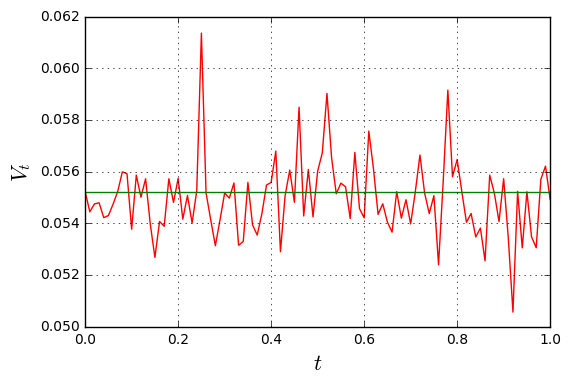

In [16]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], np.mean(V, axis = 0), 'r')
axes.plot(rB.t[0,:], 0.235**2 * np.ones_like(rB.t)[0,:], 'g')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(V[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$V_t$', fontsize=16)
plt.grid(True)

and the expectation of price process, $$\mathbb{E}[S_t] = 1$$

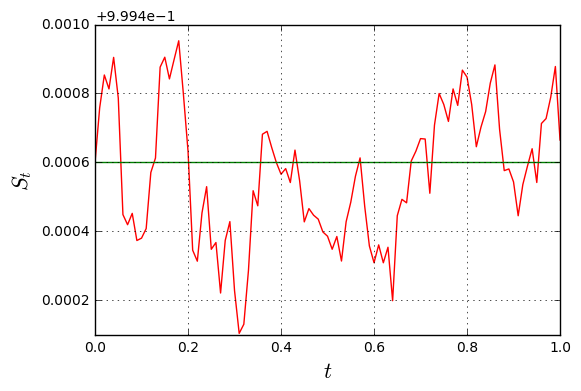

In [17]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], np.mean(S, axis = 0), 'r')
axes.plot(rB.t[0,:], np.ones_like(rB.t[0,:]), 'g')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(S[:paths,:]), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$S_t$', fontsize=16)
plt.grid(True)

Finally check the log-price process's expectation, $$-2\mathbb{E}[\log{S_t}] = \int_0^t \mathbb{E}[V_t]\mathrm{d}u = \xi t$$

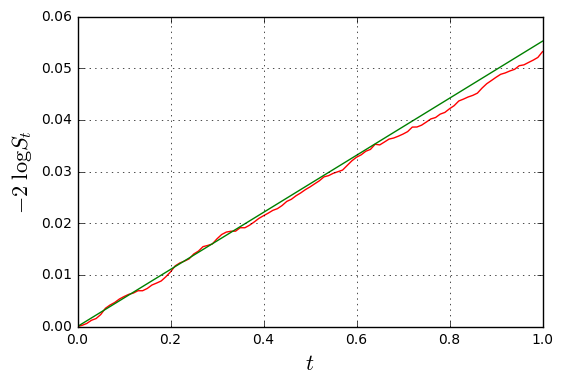

In [18]:
plot, axes = plt.subplots()
axes.plot(rB.t[0,:], -2*np.mean(np.log(S), axis=0), 'r')
axes.plot(rB.t[0,:], 0.235**2 * rB.t[0,:], 'g')
if paths > 0:
    axes.plot(rB.t[0,:], np.transpose(-2*np.log(S[:paths,:])), lw=0.5)   
axes.set_xlabel(r'$t$', fontsize=16)
axes.set_ylabel(r'$-2\ \log S_t$', fontsize=16)
plt.grid(True)